# Information theory: the noisy binary symmetric channel

Florent Leclercq,<br/>
Imperial Centre for Inference and Cosmology, Imperial College London,<br/>
florent.leclercq@polytechnique.org

In [1]:
import numpy as np
from scipy.special import binom
from matplotlib import pyplot as plt
from PIL import Image
np.random.seed(123456)
%matplotlib inline
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 16})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 16})
plt.rcParams.update({'ytick.labelsize': 16})
plt.rcParams.update({'legend.fontsize': 16})
plt.rcParams.update({'figure.titlesize': 16})

## The signal

In [2]:
# Open the image and convert it to an array of black/white pixels
im_data = Image.open('data/correlation.png')
im_grey = im_data.convert('L')
signal = np.array(im_grey, dtype=np.int)
signal[np.where(signal>1)]=1

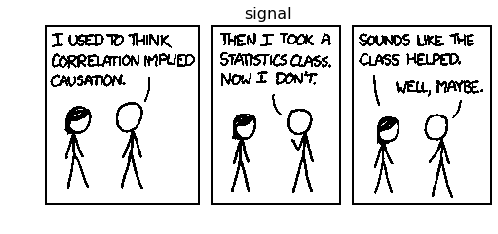

In [3]:
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(signal,cmap="Greys_r",interpolation=None)
plt.title("signal")
plt.show() 

## The noisy binary symmetric channel

The channel flips bits with a probability $f$: the noise level.

In [4]:
def noisy_channel(transmitted,noise_level):
    received=np.copy(transmitted)
    noise=np.random.uniform(size=received.shape)
    received[np.where(noise<noise_level)]+=1
    return np.mod(received,2)

In [5]:
noise_level=0.1

In [6]:
sent=np.array((1,0,1,1,1,0,1,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0))
received=noisy_channel(sent,noise_level)
print("sent :\t\t"+str(sent))
print("received :\t"+str(received))

sent :		[1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0]
received :	[1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0]


In [7]:
noisy_signal=noisy_channel(signal,noise_level)

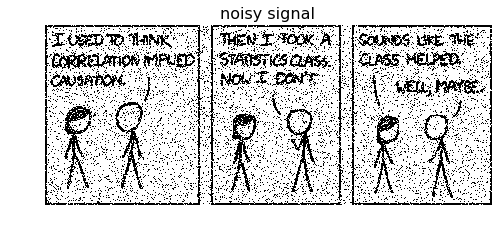

In [8]:
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(noisy_signal,cmap="Greys_r",interpolation=None)
plt.title("noisy signal")
plt.show() 

## The R3 code

The R3 code is one of the simplest algorithms: the encoder just repeats the signal 3 times. The decoder uses a "majority vote" to decide the value of each bit of the decoded signal.

In [9]:
def R3_encoder(signal):
    m1=np.copy(signal)
    m2=np.copy(signal)
    m3=np.copy(signal)
    return np.array((m1,m2,m3))

def R3_decoder(received):
    decoded=np.zeros_like(received[0])
    decoded[np.where(received[0]+received[1]+received[2]>=2)]=1
    return decoded

In [10]:
transmitted=R3_encoder(signal)

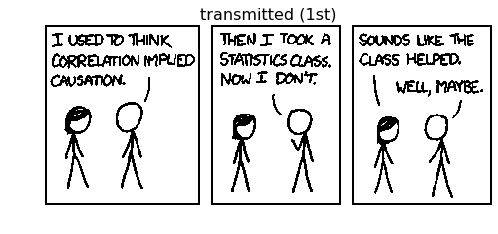

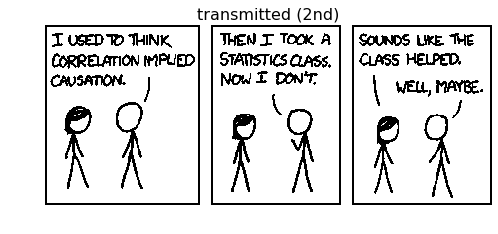

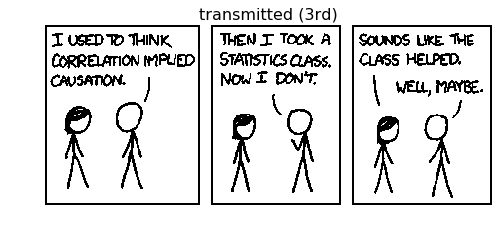

In [11]:
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(transmitted[0],cmap="Greys_r",interpolation=None)
plt.title("transmitted (1st)")
plt.show()
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(transmitted[1],cmap="Greys_r",interpolation=None)
plt.title("transmitted (2nd)")
plt.show()
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(transmitted[2],cmap="Greys_r",interpolation=None)
plt.title("transmitted (3rd)")
plt.show()

In [12]:
received=noisy_channel(transmitted,noise_level)

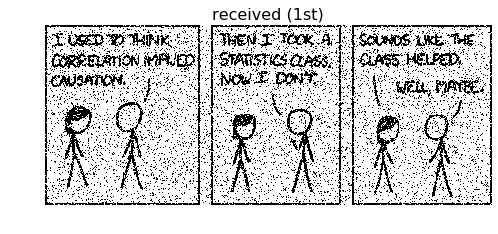

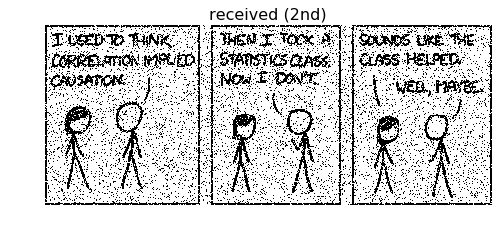

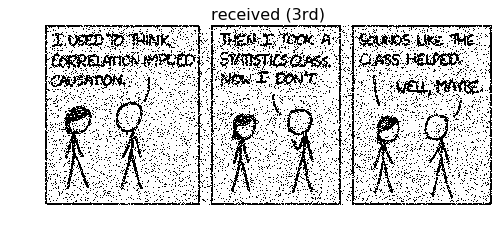

In [13]:
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(received[0],cmap="Greys_r",interpolation=None)
plt.title("received (1st)")
plt.show()
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(received[1],cmap="Greys_r",interpolation=None)
plt.title("received (2nd)")
plt.show()
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(received[2],cmap="Greys_r",interpolation=None)
plt.title("received (3rd)")
plt.show()

In [14]:
decoded=R3_decoder(received)

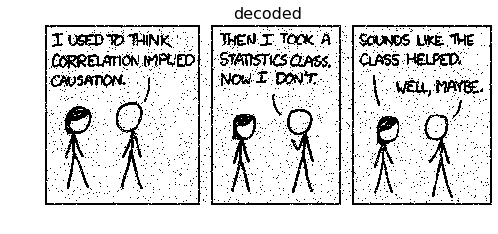

In [15]:
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(decoded,cmap="Greys_r",interpolation=None)
plt.title("decoded")
plt.show()

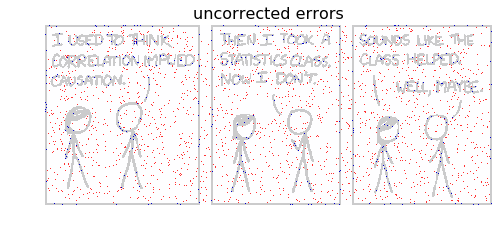

In [16]:
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(decoded-signal,cmap="bwr_r",interpolation=None)
plt.imshow(signal,cmap="Greys_r",alpha=0.2,interpolation=None)
plt.title("uncorrected errors")
plt.show() 

Uncorrected errors are uncorrelated with the R3 code.

## The (7,4) Hamming code

The (7,4) Hamming code transmits the information by blocs of 4 bits $s_1$, $s_2$, $s_3$, $s_4$. For each block of 4 bits, 3 parity-checks bits $t_5$, $t_6$ and $t_7$ are also transmitted.
The syndrome matrix allows to decode.

In [17]:
Hamming_matrix=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],[1,1,1,0],[0,1,1,1],[1,0,1,1]])
syndrome_matrix=np.array([[1,1,1,0,1,0,0],[0,1,1,1,0,1,0],[1,0,1,1,0,0,1]])

# This function splits the full signal into 4-bit blocks, adding dummy bits at the end if necessary
def split_signal_4bits_blocks(signal):
    split=signal.reshape(signal.shape[0]*signal.shape[1])
    N_dummy_bits=-len(split)%4
    split=np.concatenate((split,np.zeros(N_dummy_bits)))
    return np.split(split,len(split)/4)

# This is the Hamming encoder: transmitted = Hamming_matrix.dot(signal) for each 4-bit block
def Hamming_encoder(signal):
    split_signal=split_signal_4bits_blocks(signal)
    transmitted=np.zeros((len(split_signal),7),dtype=np.int)
    for i in range(len(split_signal)):
        signal_block=split_signal[i]
        transmitted_block=Hamming_matrix.dot(signal_block)
        transmitted[i]=transmitted_block
    return np.mod(transmitted,2)

# This function computes the syndrome: syndrome = syndrome_matrix.dot(received) for each 7-bit block
def compute_syndrome(received_block):
    return np.mod(syndrome_matrix.dot(received_block),2)

# This function corrects the error in a received block, given its syndrome
def correct_block(received_block):
    syndrom=compute_syndrome(received_block)
    corrected_block=np.copy(received_block)
    if np.array_equal(syndrom,np.array((0,0,1))):
        corrected_block[6]+=1
    elif np.array_equal(syndrom,np.array((0,1,0))):
        corrected_block[5]+=1
    elif np.array_equal(syndrom,np.array((0,1,1))):
        corrected_block[3]+=1
    elif np.array_equal(syndrom,np.array((1,0,0))):
        corrected_block[4]+=1
    elif np.array_equal(syndrom,np.array((1,0,1))):
        corrected_block[0]+=1
    elif np.array_equal(syndrom,np.array((1,1,0))):
        corrected_block[1]+=1
    elif np.array_equal(syndrom,np.array((1,1,1))):
        corrected_block[2]+=1
    return np.mod(corrected_block,2)

# This function translates corrected 7-bits blocks into 4-bit decoded blocks and removes dummy bits at the end 
def reshape_corrected_7bits_blocks(corrected,signal_shape):
    decoded=np.zeros((corrected.shape[0],4))
    
    # for each 7-bits block, keep only the 4 decoded bits
    for i in range(corrected.shape[0]):
        corrected_block=corrected[i]
        decoded[i]=np.array((corrected_block[0],corrected_block[1],corrected_block[2],corrected_block[3])
                            ,dtype=np.int)
    decoded=decoded.flatten()
    signal_length=signal_shape[0]*signal_shape[1]
    
    # remove dummy bits at the end if necessary
    N_dummy_bits=-signal_length%4
    decoded=decoded[:-N_dummy_bits]
    decoded=decoded.reshape(signal_shape[0],signal_shape[1])    
    return decoded

def reshape_parity_7bits_blocks(corrected,signal_shape):
    parity=np.zeros((corrected.shape[0],3))

    # for each 7-bits block, keep only the 4 decoded bits
    for i in range(corrected.shape[0]):
        corrected_block=corrected[i]
        parity[i]=np.array((corrected_block[4],corrected_block[5],corrected_block[6]),dtype=np.int)
    
    # reshape the array of parity bits to plot it as an image. dimensions are arbitrary here
    parity=parity.flatten()
    j=1
    d=1
    while(j<np.sqrt(len(parity))):
        if len(parity) % j == 0:
            d=j
        j+=1
    
    parity=parity.reshape(d,-1)
    return parity

# This is the Hamming decoder
def Hamming_decoder(received,signal_shape):
    corrected=np.copy(received)
    for i in range(received.shape[0]):
        received_block=received[i]
        corrected_block=correct_block(received_block)
        corrected[i]=corrected_block
    return reshape_corrected_7bits_blocks(corrected,signal_shape)

In [18]:
transmitted=Hamming_encoder(signal)
transmitted_parity=reshape_parity_7bits_blocks(transmitted,signal.shape)

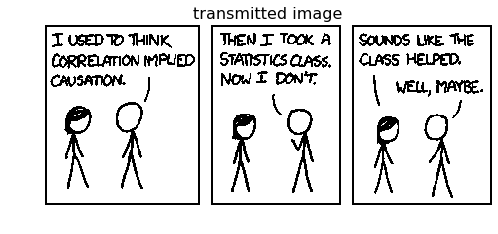

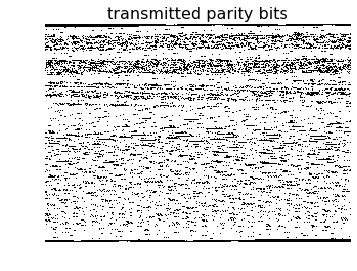

In [19]:
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(signal,cmap="Greys_r",interpolation=None)
plt.title("transmitted image")
plt.show()
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(transmitted_parity,cmap="Greys_r",interpolation=None)
plt.title("transmitted parity bits")
plt.show()

In [20]:
received=noisy_channel(transmitted,noise_level)
received_image=reshape_corrected_7bits_blocks(received,signal.shape)
received_parity=reshape_parity_7bits_blocks(received,signal.shape)

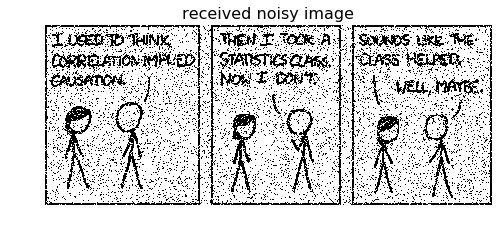

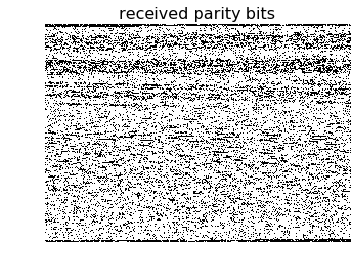

In [21]:
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(received_image,cmap="Greys_r",interpolation=None)
plt.title("received noisy image")
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(received_parity,cmap="Greys_r",interpolation=None)
plt.title("received parity bits")
plt.show()

In [22]:
decoded=Hamming_decoder(received,signal.shape)

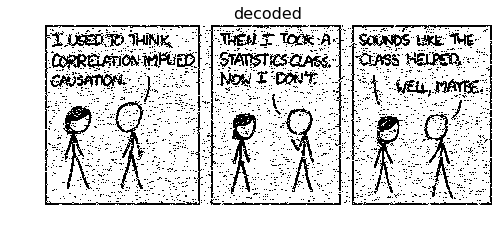

In [23]:
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(decoded,cmap="Greys_r",interpolation=None)
plt.title("decoded")
plt.show() 

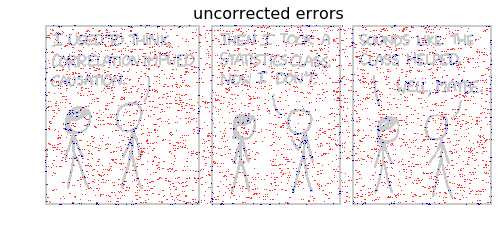

In [24]:
plt.figure(figsize=(8,4))
plt.axis('off')
plt.imshow(decoded-signal,cmap="bwr_r",interpolation=None)
plt.imshow(signal,cmap="Greys_r",alpha=0.2,interpolation=None)
plt.title("uncorrected errors")
plt.show()

There are more errors with the (7,4) Hamming code than with the R3 code, which is unsurprising since the *rate of information transfer* is $R = \frac{4}{7} > \frac{1}{3}$. Uncorrected errors are correlated, they happen preferentially in blocks of 4 consecutive bits.

## Shannon's noisy channel coding theorem

Rate of information transfer $R$ and probability of error $p_\mathrm{b}$ of repetition codes: for odd $N$:
\begin{equation}
R=\frac{1}{N}
\end{equation}
\begin{equation}
p_\mathrm{b}=\sum_{(N+1)/2}^{N} \binom{N}{n} \, f^n (1-f)^{N-n}
\end{equation}
(MacKay 2003, equation (1.24))

In [25]:
R=np.array([1./N for N in range(1,62,2)])
p=np.array([np.sum(np.array([binom(N,n)*noise_level**n*(1-noise_level)**(N-n)
                             for n in range((N+1)//2,N)])) for N in range(1,62,2)])
p[0]=noise_level

*Binary entropy function*:
\begin{equation}
H_2(x) \equiv x \log \frac{1}{x} + (1-x)\log \frac{1}{1-x}
\end{equation}
*Capacity* of the noisy channel:
\begin{equation}
C(f) \equiv 1 - H_2(f)
\end{equation}
Shannon limit:
\begin{equation}
R=\frac{C(f)}{1-H_2(f)}
\end{equation}

In [26]:
def H2(f):
    return f*np.log2(1./f) + (1-f)*np.log2(1./(1-f))
def capacity(noise_level):
    return 1.-H2(noise_level)
def shannon_limit(p,noise_level):
    return capacity(noise_level)/(1-H2(p))

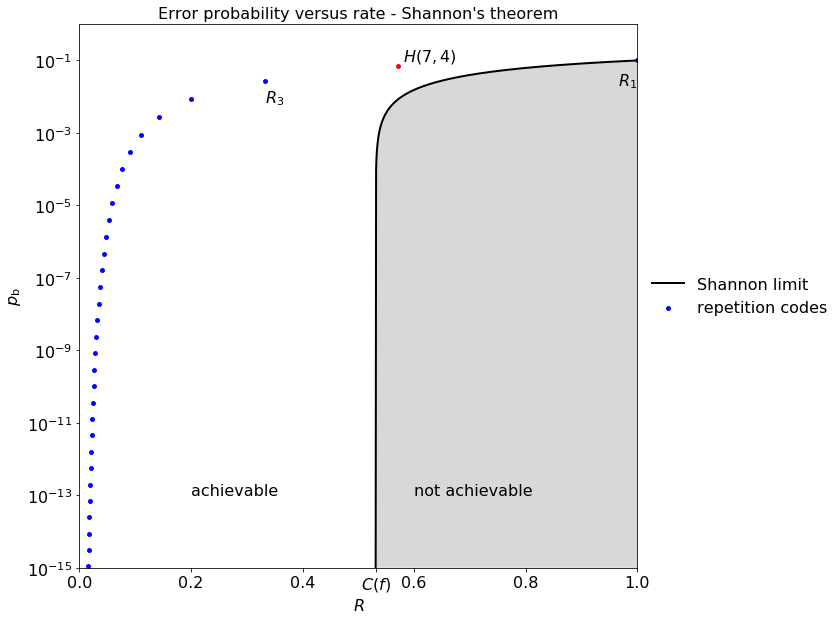

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0,1)
ax.set_xlabel("$R$")
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, capacity(noise_level)])
ax.set_xticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0", "$C(f)$"])
ax.set_yscale('log')
ax.set_ylim([1e-15,1e0])
ax.set_ylabel("$p_\mathrm{b}$")
ax.scatter(R,p,s=60,marker='.',color='blue',label="repetition codes")
ax.scatter([4./7.],[7e-2],s=60,marker='.',color='red')
p_shannon=np.linspace(noise_level,1e-15,1000)
ax.plot(shannon_limit(p_shannon,noise_level),p_shannon,color='black',lw=2,label="Shannon limit")
ax.fill_betweenx(p_shannon,shannon_limit(p_shannon,noise_level),np.ones_like(p_shannon),
                 facecolor='grey',alpha=0.3, linewidth=0.)
ax.set_title("Error probability versus rate - Shannon's theorem")
ax.text(0.333, 7e-3, '$R_3$', fontsize=16)
ax.text(0.965, 2e-2, '$R_1$', fontsize=16)
ax.text(0.58, 1e-1, '$H(7,4)$', fontsize=16)
ax.text(0.2, 1e-13, 'achievable', fontsize=16)
ax.text(0.6, 1e-13, 'not achievable', fontsize=16)
plt.legend(frameon=False,loc='center left',bbox_to_anchor=(1, 0.5))
plt.show()

Shannon's noisy-channel coding theorem: rates above the Shannon limit are achievable, rates below the Shannon limit are not achievable.

Rates up to $R=C(f)$ are achievable with arbitrarily small $p_\mathrm{b}$. The boundary between achievable and non-achievable points meets the $R$ axis at a *non-zero* value $R=C(f)$.